In [1]:
# Import C++ perceptron implementation
import neuralnet as nn
# Import other libraries
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

In [2]:
# Load training data
TRAIN_RNA = np.genfromtxt('data/training_set_rna.csv', delimiter=',', skip_header=1)[:,1:]

TRAIN_ADT = np.genfromtxt('data/training_set_adt.csv', delimiter=',', skip_header=1, dtype=int)[:,1:]

TEST_RNA = np.genfromtxt('data/test_set_rna.csv', delimiter=',', skip_header=1)[:,1:]


# Define a function to format and save data for submission
def save_result(data, filename):
    if not ('.csv' in filename):
            filename += '.csv'

    # Format results in the format kaggle wants 
    results_out = [["\"Id\"","\"Expected\""]]
    num = 1
    for i in range(0, data.shape[1]):
        for j in range(0, data.shape[0]):
            results_out.append([f"\"ID_{num}\"", f"\"{data[j,i]}\""])
            num += 1

    np.savetxt(F"results/{filename}", results_out, delimiter=',', fmt="%s")

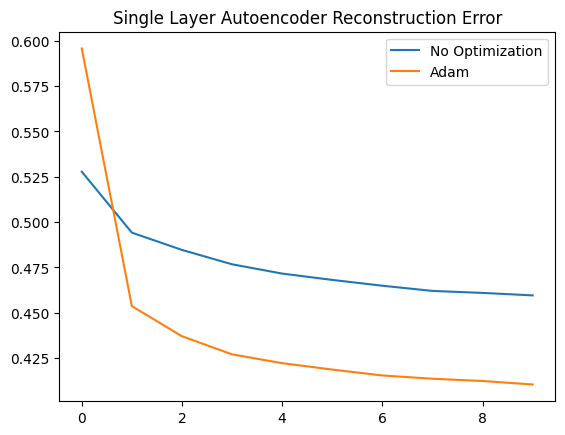

In [3]:
model = nn.Autoencoder(TRAIN_RNA.shape[0], 40)
errors_noopt = model.train(TRAIN_RNA, 0.00001, 10)
model = nn.Autoencoder(TRAIN_RNA.shape[0], 40)
errors_adam = model.train(TRAIN_RNA, 0.00001, 10, 0.99, 0.99)

x = range(len(errors_noopt))
plt.title("Single Layer Autoencoder Reconstruction Error")
plt.plot(x, errors_noopt, label = "No Optimization")
plt.plot(x, errors_adam, label = "Adam")
plt.legend()
plt.show()

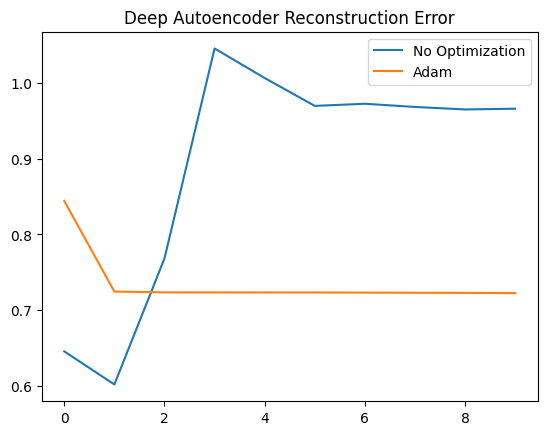

In [4]:
model = nn.VariationalAutoencoder([TRAIN_RNA.shape[0], 80, 40, 10])
errors_noopt = model.train(TRAIN_RNA, 0.00001, 10)
model = nn.VariationalAutoencoder([TRAIN_RNA.shape[0], 80, 40, 10])
errors_adam = model.train(TRAIN_RNA, 0.00001, 10, 0.99, 0.99)

plt.title("Variational Autoencoder Reconstruction Error")
x = range(len(errors_noopt))
plt.plot(x, errors_noopt, label = "No Optimization")
plt.plot(x, errors_adam, label = "Adam")
plt.legend()
plt.show()


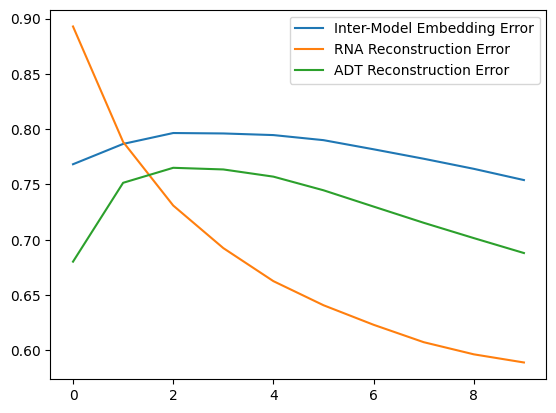

In [5]:
translator = nn.CoupledAutoencoder(
    [TRAIN_RNA.shape[0]], 
    [TRAIN_ADT.shape[0]],
40)
errors = translator.train(TRAIN_RNA, TRAIN_ADT, 0.00001, 40, 0.00000001, 0.99, 0.99)
x = range(len(errors))
plt.plot(x, [e[0] for e in errors], label = "Inter-Model Embedding Error")
plt.plot(x, [e[1] for e in errors], label = "RNA Reconstruction Error")
plt.plot(x, [e[2] for e in errors], label = "ADT Reconstruction Error")
plt.legend()
plt.show()

In [6]:
dims = [TRAIN_RNA.shape[0], int((TRAIN_RNA.shape[0] + TRAIN_ADT.shape[0]) / 2), TRAIN_ADT.shape[0]]
model = nn.Network(
    dims,    
    [nn.ActivationFunctions.ReLU] * (len(dims)-1)
)
errors = model.train(
    [TRAIN_RNA[:,i] for i in range(TRAIN_RNA.shape[1])], 
    [TRAIN_ADT[:,i] for i in range(TRAIN_ADT.shape[1])], 
    0.00001, 10,
    0.99, 0.99
)
plt.plot(range(len(errors)), errors)
plt.title("Neural Network RNA to ADT Translator")
plt.show()

In [ ]:
test_adt = np.zeros((TRAIN_ADT.shape[0], TEST_RNA.shape[1]))
for i in range(TEST_RNA.shape[1]):
    test_adt[:,i] = model.forward(TEST_RNA[:,i])
save_result(test_adt, "neuralnet_translate.csv")